<a href="https://colab.research.google.com/github/peppermintbird/nabs-prototype/blob/main/snn_proto_exo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Note and objective

This notebook is a compendium of snnTorch's tutorials, Kaggle's competition datasets, and my own coding, notes, and experiments.  

However, the main structure of this model is from [snnTorch's dataset tutorial series: Exoplanet Hunter](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_exoplanet_hunter.html), written by Ruhai Lin, Aled dela Cruz, and Karina Aguilar.

Here, I aim to provide a simple overview of how SNN can serve as an architecture for an exoplanet detection deep learning model. I'll then explain how the code relates to the data analysis.



---

### Data source

In the context of promising space missions like NASA's Kepler and TESS missions, there were three main types of astronomical observation data—target pixel files, light curves, and tabular stellar information.


In this small model, because of time and resources constraints, we will use light curve data from the Kepler space telescope that was cleaned and orginized in this [Kaggle](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data) dataset.

Kepler was a space telescope mission launched by NASA with the specially designed to discover Earth-sized exoplanets orbiting other stars in the Milky Way within their habitable zones.


It operated from 2009 to 2018. Kepler used the transit method to detect exoplanets, providing a dataset of photometric time series data for numerous stars. This data, which has already been denoised and cleaned of artifacts, is publicly available in the [Mikulski Archive](https://archive.stsci.edu/missions-and-data/kepler) and in the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/docs/KeplerMission.html).

> **Acknowledging limitations**

- Kepler primarily provides photometric measurements (brightness) rather than detailed spectral information.
- Since Kepler has a **large** dataset, preprocessing and cleaning the data is a challenge within this project’s constraints. In this model, I’m using WΔ's cleaned dataset, which is hosted on [Kaggle](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data/data). There is also more information on WΔ’s [GitHub repository](https://github.com/winterdelta/KeplerAI).
- According to WΔ, Kepler's Campaign 3 data is utilized to focus on a subset of data considered to be of higher reliability. Even so, it is unclear what selection criteria or processing steps WΔ applies to the dataset curation.


---

### Data setup and preprocessing

First of all, ensure you have the needed requirements to use snnTorch. [By following PyPi's latest version of snnTorch](https://pypi.org/project/snntorch/), you should find a quick start in how to setup the package.

* Install or collect the following packages and libraries; ignore those you already have installed. Optionally, add the `--quiet` flag to avoid cumbersome output messages.

In [ ]:
!pip install snntorch
!pip install torch
!pip install imblearn
!pip install torchvision
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install plotly.express



* Now import those packages.

In [ ]:
# importing snnTorch
import snntorch as snn
from snntorch import surrogate

# setting pyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# SMOTE (oversampling to balance the dataset)
from imblearn.over_sampling import SMOTE
from collections import Counter

# plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# metric (AUC, ROC, sensitivity & specificity)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


* Download the dataset from [Kaggle](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data/data) and then export it to Google Drive if you're using Google Colab. To ensure your files are accessible on Google Colab, mount them at `/content/drive` to connect your Drive to Google Colab.

  * For this small project we will use tested datasets:
    1. `exoTest.csv`
    2. `exoTrain.csv`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/SNN'



/content/drive/MyDrive/SNN


Just to be _sure_, let's see if the files can indeed be found.

In [ ]:
!ls exoTest.csv exoTrain.csv

exoTest.csv  exoTrain.csv


- The next step is optional, but I think it's good if you didn't get to understand the data you're handling.

> **Reminder:**

Var 1 = Contain the label attribute stating:
      
  - 1 = not exoplanet

  - 2 = exoplanet

 If 1 and 2 are somewhat inconvenient, don't worry, we will change these label values into more intuitive ones, like 0 and 1.


Var 2 - 3098 = Contain the flux values measured at different points in time.

* Read your datasets by stating:   

In [ ]:
exoTest = pd.read_csv('/content/drive/MyDrive/SNN/exoTest.csv')
exoTrain = pd.read_csv('/content/drive/MyDrive/SNN/exoTrain.csv')

exoTest.tail(10) # you can input here the number of rows you wish to peruse

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
560,1,5.66,7.83,-4.39,-0.62,-5.23,0.34,-13.64,-11.26,-9.96,...,15.15,24.89,23.41,26.33,44.37,46.15,37.28,45.60,41.66,39.35
561,1,4.36,2.22,5.61,-1.44,-0.05,-0.22,1.28,-13.20,-5.83,...,2.94,-2.90,2.12,11.26,12.81,6.03,-6.13,-10.46,-5.36,-14.23
562,1,-79.95,-79.13,-81.07,-72.25,-79.71,-70.60,-90.33,-88.66,-68.15,...,5.40,19.51,-0.15,1.67,3.20,7.25,-8.25,-7.91,4.45,6.58
563,1,-63.42,-59.78,-64.16,-61.07,-41.74,-58.99,-35.94,-43.15,-24.87,...,-13.98,0.62,-5.53,-14.26,-23.69,-37.84,-2.37,6.62,12.02,2.33
564,1,144.47,20.09,147.47,109.18,100.87,24.87,115.03,106.37,48.87,...,-57.53,-41.94,-165.94,-265.13,-263.35,-376.53,-176.22,-152.07,-216.60,-202.97
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60
569,1,3071.19,2782.53,2608.69,2325.47,2089.37,1769.56,1421.09,1142.09,902.31,...,695.41,865.97,882.41,1203.06,1293.03,1354.41,-192.81,-277.22,-69.63,121.56


In [ ]:
exoTrain.tail(10)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
5077,1,125.57,78.69,98.29,91.16,78.42,45.82,61.69,22.73,39.09,...,32.35,63.23,57.98,90.43,115.12,210.09,3.80,16.33,27.35,21.30
5078,1,7.45,10.02,6.87,-2.82,-1.56,-4.30,-7.01,-6.97,-2.54,...,-5.25,-8.56,0.53,-4.29,-6.60,8.75,-10.69,-9.54,-2.48,-8.69
5079,1,475.61,395.50,423.61,376.36,338.94,321.26,326.34,342.84,251.23,...,543.25,453.87,344.35,266.16,242.18,163.02,86.29,13.06,161.22,213.60
5080,1,-46.63,-55.39,-64.88,-88.75,-75.40,-64.06,-66.37,-41.95,-68.07,...,29.64,6.90,32.94,56.63,28.71,28.82,-20.12,-14.41,-43.35,-30.04
5081,1,299.41,302.77,278.68,263.48,236.89,186.93,145.45,151.20,123.38,...,-126.36,-133.82,-134.02,-98.76,-106.60,-74.95,-46.29,-3.08,-28.43,-48.68
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55
5086,1,323.28,306.36,293.16,287.67,249.89,218.30,188.86,178.93,118.93,...,71.19,0.97,55.20,-1.63,-5.50,-25.33,-41.31,-16.72,-14.09,27.82


In [ ]:
print(exoTest['LABEL'].value_counts())
print(exoTrain['LABEL'].value_counts())

1    565
2      5
Name: LABEL, dtype: int64
1    5050
2      37
Name: LABEL, dtype: int64


> **Key takeways:**

- You should notice the large imbalance in those datasets. Because of that, we will apply SMOTE to regularize the data later on in this notebook.

- From the print function we could see that, in both datasets, the number of positive samples is overwhelmingly smaller than the negative ones. Soon we will further analyze the disparity between samples in the training dataset, which will be our main focus.




Hooray! Now that the setup is done, let's customize the dataset to our needs. We'll also augment the data to adress the imbalance issue.



---

### Data customization and augmentation

#### **Customization**

- Continuing on the data preprocessing, we will use PyTorch to custom the data.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        with open(csv_file,"r") as f:
            self.data = pd.read_csv(f) # read the files
        self.labels = self.data.iloc[:,0].values - 1 # set the first line of the input data as the label (Originally 1 or 2, but we will transform them into 0 or 1 by decreasing 1)
        self.features = self.data.iloc[:, 1:].values # set the rest of the input data as the feature (FLUX over time)
        self.transform = transform # transformation (which is None) that will be applied to samples.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): # retrieves a data sample from the dataset
            label = self.labels[idx] # fetch label of sample
            feature = self.features[idx] # fetch features of sample

            if self.transform: # if there is a specified transformation, transform the data
                feature = self.transform(feature)

            sample = {'feature': feature, 'label': label}
            return sample

# instantiate train and test datasets
train_dataset = CustomDataset('./exoTrain.csv') # grab the training data
test_dataset = CustomDataset('./exoTest.csv') # grab the test data


 Following [PyTorch's official tutorial for deep learning frameworks](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html), we have the CSV file opened and its contents read using `pd.read_csv()` from the Pandas library.

 The data is stored in the `self.data` attribute. The labels are extracted from the first column `(iloc[:,0])` of the data using `.values`.

 The labels are then transformed by subtracting 1, converting them from 1 or 2 to 0 or 1 respectively. These transformed labels are stored in the `self.labels` attribute.

In [ ]:
    def __len__(self): # function that gives back the size of the dataset (how many samples)
            return len(self.labels)

    def __getitem__(self, idx): # retrieves a data sample from the dataset
            label = self.labels[idx] # fetch label of sample
            feature = self.features[idx] # fetch features of sample

            if self.transform: # if there is a specified transformation, transform the data
                feature = self.transform(feature)

            sample = {'feature': feature, 'label': label}
            return sample

    train_dataset = CustomDataset('./exoTrain.csv') # grab the training data
    test_dataset = CustomDataset('./exoTest.csv') # grab the test data






To check if the transformation was successful, you can call a print function as we did before, but this time adding `pd.Series`.

In [ ]:
print("LABEL:", pd.Series(test_dataset.labels).value_counts())
print("LABEL:", pd.Series(train_dataset.labels).value_counts())

LABEL: 0    565
1      5
dtype: int64
LABEL: 0    5050
1      37
dtype: int64


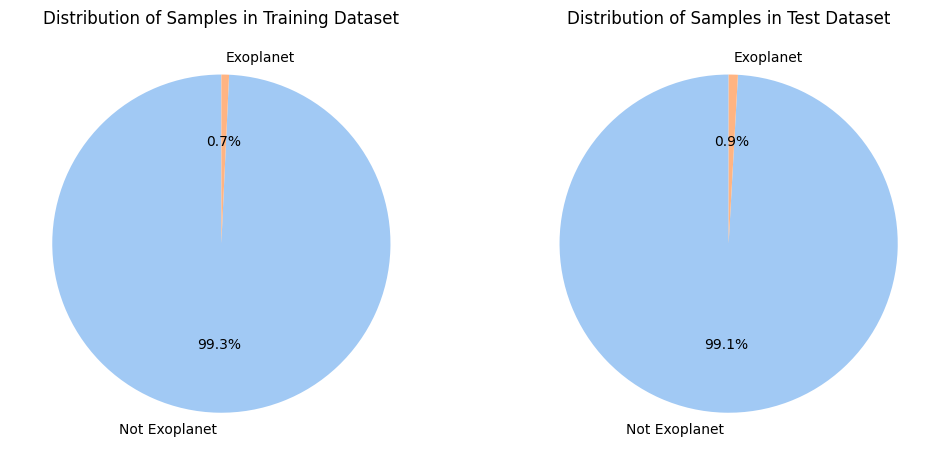

In [ ]:
label_counts = np.bincount(train_dataset.labels)
label_names = ['Not Exoplanet','Exoplanet']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, dataset in enumerate([train_dataset, test_dataset]):
    label_counts = np.bincount(dataset.labels)
    axes[i].pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    axes[i].set_title('Distribution of Samples in ' + ['Training', 'Test'][i] + ' Dataset')

plt.show()

It's evident that the training dataset exhibits slightly more imbalance compared to the test dataset.

#### **Augmentation**

According to [Chawla, Bowyer, et al. (2002)](https://www.jair.org/index.php/jair/article/view/10302), Synthetic Minority Over-Sampling Technique (SMOTE) combines under-sampling of the majority class -- in our case, the negative samples of exoplanet candidates -- with a unique form of over-sampling the minority class to address class imbalance.

So, in essence, SMOTE balances the samples by creating synthetic data points from the minority class.

In [ ]:


# initialize smote with default sampling strategy
smote = SMOTE()


# update the labels and features to the resampled data
train_dataset.features, train_dataset.labels = smote.fit_resample(train_dataset.features, train_dataset.labels)


print("Class distribution in the testing dataset after SMOTE:", pd.Series(test_dataset.labels).value_counts())
print("Class distribution in the training dataset after SMOTE:", pd.Series(train_dataset.labels).value_counts())

Class distribution in the testing dataset after SMOTE: 0    565
1      5
dtype: int64
Class distribution in the training dataset after SMOTE: 1    5050
0    5050
dtype: int64


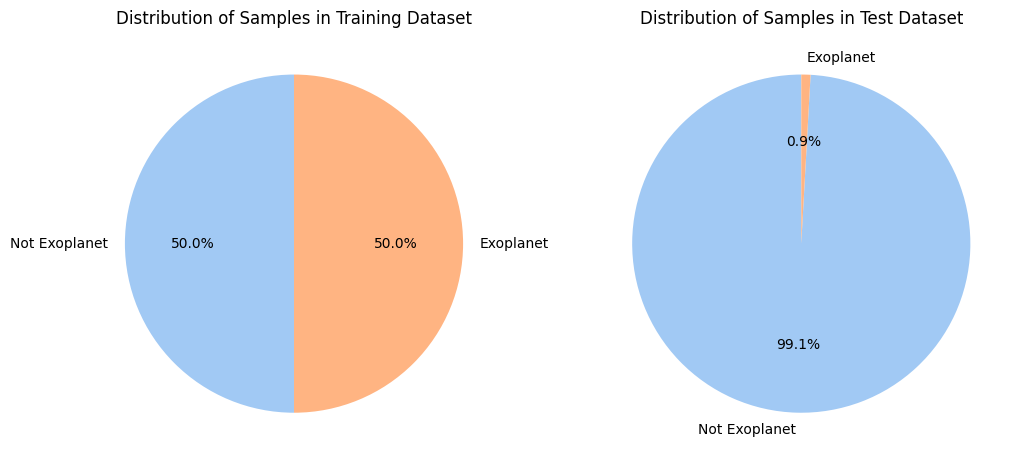

In [ ]:
label_counts = np.bincount(train_dataset.labels)
label_names = ['Not Exoplanet','Exoplanet']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, dataset in enumerate([train_dataset, test_dataset]):
    label_counts = np.bincount(dataset.labels)
    axes[i].pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    axes[i].set_title('Distribution of Samples in ' + ['Training', 'Test'][i] + ' Dataset')

plt.show()

> **Reminder:**

The goal of machine learning models is to generalize well to unseen data. By applying SMOTE only to the training dataset, the model learns to better represent the **underlying patterns** in the data while avoiding overfitting. This ensures that the model's performance on real-world data is more reliable.



---







### DataLoader

Creating a DataLoader allows us, among other things, to load data in batches, making it easier to process large datasets without loading everything into memory at once.


It also can shuffle the data, which is important for training models to prevent the model from learning the order of the data!

In [ ]:
# number of samples in each batch during training
batch_size = 64

spike_grad = surrogate.fast_sigmoid(slope=25)

# initialize a beta value of 0.5
beta = 0.5


# create a dataloader for the testset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# create a dataloader for the trainset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
print(train_dataset.data.head(1))

   LABEL  FLUX.1  FLUX.2  FLUX.3  FLUX.4  FLUX.5  FLUX.6  FLUX.7  FLUX.8  \
0      2   93.85   83.81    20.1  -26.98  -39.56 -124.71 -135.18  -96.27   

   FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  FLUX.3192  \
0  -79.89  ...     -78.07    -102.15    -102.15      25.13      48.57   

   FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      92.54      39.32      61.42       5.08     -39.54  

[1 rows x 3198 columns]


In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Star #0 (Exoplanet)", "Star #1 (Exoplanet)",
                                                   "Star #3000 (No-Exoplanet)", "Star #3001 (No-Exoplanet)"))
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(0)['feature']),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(1)['feature']),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(3000)['feature']),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(3001)['feature']),
    row=2, col=2
)
for i in range(1, 5):
    fig.update_xaxes(title_text="Time", row=(i-1)//2 + 1, col=(i-1)%2 + 1)
    fig.update_yaxes(title_text="Flux", row=(i-1)//2 + 1, col=(i-1)%2 + 1)

fig.update_layout(height=600, width=800, title_text="Exoplanets Flux vs No-Exoplanet Flux",showlegend=False)
fig.show()

---


### Model network

- Let's define a neural network model called `Net` using PyTorch's `nn.Module`.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers (3 linear layers and 3 leaky layers)
        self.fc1 = nn.Linear(3197, 128) # takes an input of 3197 and outputs 128
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(64, 64) # takes an input of 64 and outputs 68
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(32, 2) # takes in 32 inputs and outputs our two outputs (planet with/without an exoplanet)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.softmax = nn.Softmax(dim=1) # softmax applied with a dimension of 1

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        cur1 = F.max_pool1d(self.fc1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool1d(self.fc2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc3(spk2.view(batch_size, -1))

        # return cur3
        return cur3

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = Net() # initialize the model to the new class.

This neural network consists of three fully connected linear layers (`fc1`, `fc2`, and `fc3`) followed by three leaky integrate-and-fire (LIF) layers (`lif1`, `lif2`, and `lif3`).



The sizes of the input and output dimensions for each linear layer are specified and a softmax layer (`softmax`) is defined to normalize the output probabilities.

For each linear layer, the program specify the number of input and output features. For example, the first linear layer takes 3197 input features and produces 128 output features.

Then, the program initialize the hidden states and outputs for each neuron in the network at time step 𝘵 = 𝟶. This is like setting up the initial conditions before we start processing the input data.

Following it's the processing of the input data through each layer of the network.

For the first linear layer (`fc1`), the program passes the input data (`x`) through the layer and apply a max pooling operation. Max pooling helps reduce the size of the data while retaining important features.

Next, it applies the leaky integrate-and-fire (`LIF`) neuron model to the output of the first layer. This simulates how neurons in the brain fire in response to stimuli.

This process is repeated for the second linear layer (`fc2`) and its corresponding LIF neuron, and then for the third linear layer (`fc3`).


Finally, we obtain the output of the last linear layer (`fc3`) and return it as the result of the forward pass.

> **Key takeways:**

- The data flows sequentially through each layer of the neural network.

- However, within each layer, there is *parallel processing* happening. Different parts of the data are being processed simultaneously.

---

### Loss function and optimizer

Originally, this model didn't use binary cross-entropy loss, but due to the nature of our classes, it can be well-suited for calculating the loss between the predicted probabilities and the true binary labels.

The optimizer continues to be the same. It updates the parameters using a small batch of training examples at a time, rather than the entire dataset (hence "stochastic").

In [ ]:
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.001) # stochastic gradient descent with a learning rate of 0.001

---

### Training and testing

Following this model original developer's advice, I left the number of epochs between 50 and 500.

In [ ]:
# create a pandas dataframe to hold the current epoch, the accuracy， sensitivity, specificity, auc-roc and loss
results = pd.DataFrame(columns=['Epoch', 'Accuracy', 'Sensitivity', 'Specificity', 'AUC-ROC', 'Test Loss'])

In [ ]:
num_epochs = 100 # initialize a certain number of epoch iterations

In [ ]:

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for data in train_dataloader:
        inputs, labels = data['feature'].float(), data['label'].float()  # Float
        optimizer.zero_grad()  # Clear previously stored gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Compute binary cross-entropy loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

    # Test Set Evaluation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_probs = []
        for data in test_dataloader:
            inputs, labels = data['feature'].float(), data['label'].float()
            outputs = model(inputs)
            test_loss += criterion(outputs.squeeze(), labels).item()  # Compute test loss
            predicted = torch.round(torch.sigmoid(outputs))  # Round to get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            probabilities = torch.sigmoid(outputs).cpu().numpy().flatten()  # Compute probabilities
            all_probs.extend(probabilities)

        accuracy = 100 * correct / total  # Calculate accuracy
        cm = confusion_matrix(all_labels, all_predicted)  # Compute confusion matrix
        tn, fp, fn, tp = cm.ravel()
        sensitivity = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Calculate sensitivity
        specificity = 100 * tn / (tn + fp) if (tn + fp) > 0 else 0.0  # Calculate specificity
        auc_roc = 100 * roc_auc_score(all_labels, all_probs)  # Calculate AUC-ROC

        # Print and store results
        print(
            f'Epoch [{epoch + 1}/{num_epochs}] Test Loss: {test_loss / len(test_dataloader):.2f} '
            f'Test Accuracy: {accuracy:.2f}% Sensitivity: {sensitivity:.2f}% Specificity: {specificity:.2f}% AUC-ROC: {auc_roc:.4f}%'
        )
        results = results.append({
            'Epoch': epoch + 1,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Test Loss': test_loss / len(test_dataloader),
            'AUC-ROC': auc_roc
        }, ignore_index=True)

---

### Visualization

In [ ]:
#@title #### Plotting the Accuracy, Sensitivity, Specificity, Test Loss, and AUC-ROC

#plot the test metrics over each epoch

# accuracy
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='Accuracy', data=results, marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# sensitivity
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='Sensitivity', data=results, marker='o', label='Sensitivity')
plt.title('Sensitivity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Sensitivity')
plt.show()

# specificity
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='Specificity', data=results, marker='o')
plt.title('Specificity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Specificity')
plt.show()

# test-loss
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='Test Loss', data=results, marker='o')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.show()

# auc-roc
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='AUC-ROC', data=results, marker='o')
plt.title('AUC-ROC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC')
plt.show()




In [ ]:
fig = make_subplots(rows=2, cols=3, subplot_titles=("Sensitivity", "Accuracy", "AUC-ROC", "Specificity", "Test Loss"))

# Sensitivity plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['Sensitivity'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=1, col=1
)
# fig.update_xaxes(title_text="Epoch", row=1, col=1)
# fig.update_yaxes(title_text="Sensitivity", row=1, col=1)

# Accuracy plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['Accuracy'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=1, col=2
)
# fig.update_xaxes(title_text="Epoch", row=1, col=2)
# fig.update_yaxes(title_text="Accuracy", row=1, col=2)

# AUC ROC plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['AUC-ROC'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=1, col=3
)
# fig.update_xaxes(title_text="Epoch", row=1, col=3)
# fig.update_yaxes(title_text="AUC ROC", row=1, col=3)

# Specificity plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['Specificity'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=2, col=1
)
# fig.update_xaxes(title_text="Epoch", row=2, col=1)
# fig.update_yaxes(title_text="Specificity", row=2, col=1)

# Test Loss plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['Test Loss'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=2, col=2
)

# Define different y-axis labels
y_labels = ['True Positive Rate (TPR)', 'Accuracy', 'AUC-ROC', 'True False Rate (TFR)', 'Test Loss']

for i in range(1, 6):
    row_num = (i - 1) // 3 + 1
    col_num = (i - 1) % 3 + 1

    fig.update_xaxes(title_text="Epochs", row=row_num, col=col_num)
    fig.update_yaxes(title_text=y_labels[i-1], row=row_num, col=col_num)

# Update layout
fig.update_layout(
    height=600,
    width=1000,
    title_text="Metrics Over Epochs",
    showlegend=False,
    margin=dict(l=50, r=50, t=80, b=50)
)

# Show the plot
fig.show()

---

### Final considerations

As noted in the original snnTorch code, outputting the accuracy rate in this SNN model for detecting exoplanets using light curve data may not be as useful.

We saw that the dataset is highly imbalanced, with a majority of examples belonging to non-exoplanets and only a few examples belonging to  exoplanets. In such cases, even a naive classifier that always predicts the majority class can achieve high accuracy. Therefore, accuracy alone may not provide a meaningful evaluation of the model's performance.

Another thing to keep in mind is that this model don't execute temporal processing, which can be interesting for spectral data.

Coming up, I intend to recreate this model to instead of processing the data in batches, explore the temporal processing of a SNN model.